In [1]:
import torch
import torch.nn as nn
from d2l.torch import d2l as d2l

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 卷积运算与卷积层

卷积运算：卷积核在输入信号（图像）上滑动，在相应位置上进行乘加。

卷积核（又称滤过器，过滤器），可认为是某种模式，某种特征

卷积过程：用一个模板去图像上寻找与它相似的区域，与卷积核模式越相似，激活值越高，从而实现特征提取。

## 1维/2维/3维卷积

卷积核在**几个维度上移动就是几维卷积**。

- 一维卷积
<img style="float: center;" src="images/1.gif" width="40%">
- 二维卷积
<img style="float: center;" src="images/2.gif" width="40%">
- 三维卷积
<img style="float: center;" src="images/3.gif" width="40%">

## nn.Conv2d

对多个二维信号进行二维卷积：

nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

主要参数：
- in_channels：输入通道数
- out_channels：输出通道数（等价于卷积核个数）
- kernel_size：卷积核尺寸（大小）
- stride：步长，卷积核每次滑动像素数（左边：步长1，右边：步长2）
<img style="float: center;" src="images/4.gif" width="40%">
- padding：填充数，保持输入和输出图像的尺寸匹配
  - 左边：没有padding，输入4 * 4，输出2 * 2，分辨率降低，边缘像素参与计算少
  - 右边：在原输入周围填充像素，保证输出尺寸分辨率和输入一样，边缘像素同等计算
<img style="float: center;" src="images/5.gif" width="40%">
- dilation：孔洞卷积（带孔的卷积核）大小，常用于图像分割，提高感受野。也就是输出图像的一个参数，能看到前面图像更大的一个区域。
<img style="float: center;" src="images/6.gif" width="40%">
- groups：分组卷积设置，常用于模型轻量化，AlexNet可以看到分组，两组卷积分别提取合并
<img style="float: center;" src="images/59.png" width="70%">
- bias：偏置

## 尺寸计算

- 没有padding：$out_{size}=\frac{In_{size}-kernel_{size}}{stride}+1$
- 有padding：$out_{size}=\frac{In_{size}+2\times padding_{size}-kernel_{size}}{stride}+1$
- 加上孔洞卷积：$out_{size}=\frac{In_{size}+2\times padding_{size}-dilation_{size}\times (kernel_{size}-1)-1}{stride}+1$

## 提取特征

<img style="float: center;" src="images/61.png" width="70%">

换一组seed结果：
<img style="float: center;" src="images/62.png" width="70%">
<img style="float: center;" src="images/63.png" width="70%">

不同权重的卷积核代表不同模式，会关注不同特征（设置多个卷积核同时对图片特征进行提取，可以提取不同的特征）

图像尺寸变化：
- 卷积前尺寸:torch.Size([1, 3, 512, 512])
- 卷积后尺寸:torch.Size([1, 1, 510, 510])

卷积核，输入通道3，卷积核个数1，大小3，无padding，步长1：

$out_{size}=\frac{In_{size}-kernel_{size}}{stride}+1=(512-3)/1+1=510$

卷积层（继承nn.Module），同样包含8个字典属性，主要看\_modules和\parameters
<img style="float: center;" src="images/64.png" width="70%">

可以看到Conv2d里\parameters存放权重参数，weight形状[1, 3, 3, 3]：
- 第1个参数1代表卷积核个数
- 第2个参数3表示输入通道数
- 第3个参数3和第4个参数3是二维卷积核尺寸

问题：这里是3维卷积核，怎么实现二维卷积呢？（看示意图）
<img style="float: center;" src="images/7.gif" width="70%">

图像是RGB3个通道，创建3个二维卷积核，分别对应一个通道进行卷积（例如红色通道上，只有一个卷积核在上面滑动，每一次滑动对应元素相乘后相加得到一个数，三个卷积核滑动一次就得到三个数，最后结果为**三个数之和加上偏置**）。

1个卷积核只在2个维度上滑动，所以最后得到的就是2维卷积（卷积核在几个维度上滑动就是几维卷积），当有多个卷积核时，每个卷积核都产生一个2维结果，则输出就为3维（第3个维度是卷积核的个数）。

下图是一个三维卷积示意，使用2个卷积核，最后得到2个二维张量：
<img style="float: center;" src="images/8.gif" width="70%">

## 转置卷积

转置卷积（反卷积、部分跨越卷积），用于对图像进行上采样（常用于图像分割）。

正常卷积：大量相乘后相加操作，借助矩阵乘法实现。

实现步骤：假设图像尺寸$4\times 4$，卷积核$3\times 3$，padding=0，stride=1：
<img style="float: center;" src="images/9.gif" width="40%">
1. 将图像尺寸$4\times 4$拉长成$16\times 1$，16代表像素数，1代表1张图片
2. $3\times 3$的卷积核变成$4\times 16$的矩阵，其中，16是先把$3\times 3$的卷积核9个权值拉成一列，再在下面补7个0变成16（与第1步像素值大小对应），4是根据输出尺寸计算，根据公式：$out_{size}=\frac{In_{size}-kernel_{size}}{stride}+1=(4-3)/1+1=2$，输出为$2\times 2=4$，拉成一列就是4.得到输出：$O_{4\times 1}=K_{4\times 16}\times I_{16\times 1}$
3. 这样就得到最后一列输出4个元素，然后reshape得到$2\times 2$的输出特征图
<img style="float: center;" src="images/65.png" width="70%">

转置卷积（一个上采样），输入尺寸比较小，经过转置卷积后，输出一个更大图像

实现步骤：假设输入图像$2\times 2$，卷积核$3\times 3$，padding=0，stride=1，输出图像$4\times 4$：
<img style="float: center;" src="images/10.gif" width="40%">
1. 将图像尺寸$2\times 2$拉长成$4\times 1$，4代表像素数，1代表1张图片
2. $3\times 3$的卷积核变成$16\times 4$的矩阵，其中，4是剔除了$3\times 3$的卷积核9个权值中的5个，得到4个权重，16是根据输出图像的尺寸计算，输出图像是$4\times 4$，$O_{16\times 1}=K_{16\times 4}\times I_{4\times 1}$
3. 注意这里卷积核的尺寸是$16\times 4$，而正常卷积为$4\times 16$，所以形状上两个卷积操作的卷积核是转置关系（故称转置卷积），但是具体数值不一样，所以正常卷积核转置卷积的关系并不是可逆的。

代码：

nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

### 转置卷积尺寸计算
- 没有padding：$out_{size}=(in_{size}-1)\times stride+kernel_{size}$
- 有padding：$out_{size}=(in_{size}-1)\times stride+kernel_{size}-2\times padding_{size}$
- 加上孔洞卷积：$out_{size}=(in_{size}-1)\times stride-2\times padding_{size}+dilation_{size}\times (kernel_{size}-1)+1$

### 代码实践

转置卷积有“棋盘效应”（不均匀重叠导致）
<img style="float: center;" src="images/66.png" width="70%">

图像尺寸变化：
- 卷积前尺寸:torch.Size([1, 3, 512, 512])
- 卷积后尺寸:torch.Size([1, 1, 1025, 1025])

输入图像512，卷积核大小3，步长2，输出尺寸：$out_{size}=(in_{size}-1)\times stride+kernel_{size}=(512-1)\times 2+3=1025$

# 池化层

池化运算：对信号进行**收集并总结**，类似水池收集水资源（故叫池化层）。
- 收集：多变少，图像尺寸减小
- 总结：最大值、平均值

<img style="float: center;" src="images/11.gif" width="40%">

**最大池化：对二维信号（图像）进行最大值池化**

nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

- kernel_size：池化核大小
- stride：步长
- padding：填充数
- dilation：池化核间隔大小
- ceil_mode：尺寸向上取整
- return_indices：记录池化像素索引（最大值反池化时使用）

最大池化效果：
<img style="float: center;" src="images/68.png" width="70%">

可以发现图像基本没有差别，但是图像的尺寸减少了一半（剔除冗余像素）

**平均池化：对二维信号（图像）进行平均池化**

nn.AvgPool2d(kernel.size, stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)

- count_include_pad：填充值用于计算
- divisor_override：除法因子，求平均时的分母，默认为池化核大小

平均池化效果：
<img style="float: center;" src="images/69.png" width="70%">

最大池化的亮度（取最大值）比平均池化（取平均值）要稍微亮一些

**反池化：对二维信号（图像）进行最大池化上采样**

根据最大值池化记录索引，在最大值反池化的时候把元素放回去。
<img style="float: center;" src="images/67.png" width="70%">

nn.MaxUnpool2d(kernel_size, stride=None, padding=0)

forward(self, input, indices, output_size=None)

这里参数与池化层类似，唯一不同是前向传播时需要传进一个indices（索引值），否则无法知道输入的元素放在哪个位置。
<img style="float: center;" src="images/70.png" width="70%">

代码操作：
<img style="float: center;" src="images/71.png" width="70%">

# 线性层

线性层（全连接层），每个神经元与上一层所有神经元相连实现对前一层的线性组合/线性变换。

对一维信号（向量）进行线性组合

nn.Linear(in_features, out_features, bias=True)
- in_features：输入节点数
- out_features：输出节点数
- bias：是否需要偏置

计算公式：$y=W^Tx+bias$
<img style="float: center;" src="images/72.png" width="70%">

In [2]:
inputs = torch.tensor([[1., 2, 3]])
linear_layer = nn.Linear(3, 4)
linear_layer.weight.data = torch.tensor([[1., 1., 1.],
                                             [2., 2., 2.],
                                             [3., 3., 3.],
                                             [4., 4., 4.]])

linear_layer.bias.data.fill_(0.5)
output = linear_layer(inputs)
print(inputs, inputs.shape)
print(linear_layer.weight.data, linear_layer.weight.data.shape)
print(output, output.shape)

tensor([[1., 2., 3.]]) torch.Size([1, 3])
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]]) torch.Size([4, 3])
tensor([[ 6.5000, 12.5000, 18.5000, 24.5000]], grad_fn=<AddmmBackward0>) torch.Size([1, 4])


# 激活函数

激活函数：对特征进行非线性变换，赋予多层神经网络具有**深度**的意义。

无激活函数：
<img style="float: center;" src="images/73.png" width="70%">

$H_1=X\times W_1, H_2=H_1\times W_2, output=H_2\times W_3=X\times W$

一个三层的全连接层，结果与一个线性层一样：因为线性运算的矩阵乘法结合率，无论多少个线性层叠加，其实就是矩阵的一个连乘，最后还是一个矩阵。

所以需要激活函数

## ReLU函数

最常使用，不容易造成梯度消失

$ReLU(x)=max(x, 0)$

$\frac{d}{dx}ReLU(x)=1(x>0),0(x\le 0)$

<img style="float: center;" src="images/74.png" width="70%">

对ReLU函数的改进：
<img style="float: center;" src="images/75.png" width="70%">

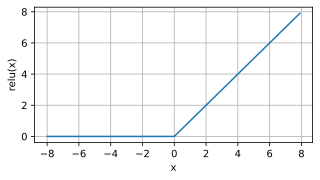

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

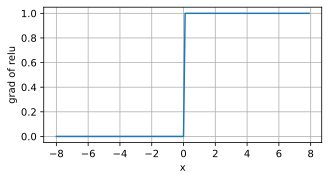

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

## sigmoid函数

$sigmoid(x)=\frac{1}{1+\exp(-x)}$，压缩范围：(0,1)

$\frac{d}{dx}sigmoid(x)=\frac{\exp(-x)}{(1+\exp(-x))^2}=sigmoid(x)(1-sigmoid(x))$，最大值：0.25

<img style="float: center;" src="images/76.png" width="70%">

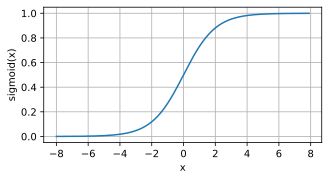

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

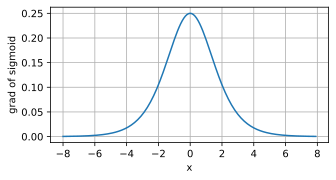

In [6]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## tanh函数

$\tanh(x)=\frac{1-\exp(-2x)}{1+\exp(-2x)}$，压缩范围：(-1,1)

$\frac{d}{dx}\tanh(x)=1-\tanh^2(x)$，最大值：1

$\tanh(x)+1=2sigmoid(2x)$

<img style="float: center;" src="images/77.png" width="70%">

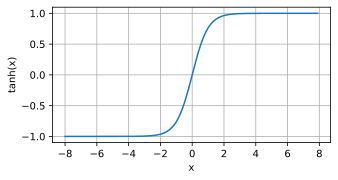

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

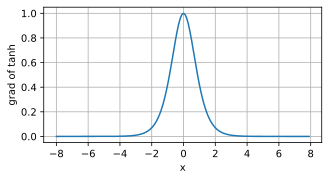

In [8]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 思维导图

<img style="float: center;" src="images/78.png" width="70%">